In order to be able to run the simulations efficiently we coded all simulation code in C++. The code requires no external libraries and should be compilable with G++ 11.4.
To run the library one must go to the Simulations folder and compile the code into a dynamically linked library by running make.
The file cpp_routines.py should be imported to Python to run the routines. The current implementation only works for Linux systems.
For more details about how to use cpp_routines library please refer to API.txt in Simulations folder

For the analysis we use mostly standard Python packages. The two exceptions are *emcee* package we use for MCMC sampling and *corner* package we use for corner plots.

In [1]:
! cd Simulations; make

Making obj directory...
mkdir obj
mkdir obj/core
Compiling run.cpp...
g++  -c -O3 -I.  -ICore  -IStrategies  -ISuppl  -o obj/run.o run.cpp
Compiling routines_lib.cpp...
g++  -c -O3 -I.  -ICore  -IStrategies  -ISuppl  -fpic -o obj/routines_lib.o routines_lib.cpp
g++  -o run  obj/run.o -lm
g++  -shared -o routines_lib.so  obj/routines_lib.o -lm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import os
import sys

import os
if not os.path.exists('Plots'):
    os.mkdir('Plots')

#Loading simulation routines
os.environ['SIMULATION_ROUTINES_PATH'] = os.getcwd() + '/Simulations/'
sys.path.append('Simulations')
import cpp_routines as sim
#Loading decision processing routines
import data_process as dp
#Loading logisic regression analysis routines
import logit_analysis as logit

# Transition table

Here we reproduce the required threshold for the number of remaining arm pulls table. The number 0 in the table indicates that no threshold was found and the exploration for such success and failure configuration should be continued indefinitely

In [3]:
trans_table = sim.optimal_transition_table(10, 10, 2000, prior=(1, 1))
print(trans_table)

[[   1    1    1    1    1    1    1    1    1    1]
 [   0    1    1    1    1    1    1    1    1    1]
 [   0   12    1    1    1    1    1    1    1    1]
 [   0   39    5    1    1    1    1    1    1    1]
 [   0   94   10    3    1    1    1    1    1    1]
 [   0  190   19    6    3    1    1    1    1    1]
 [   0  344   30   10    5    2    1    1    1    1]
 [   0  578   45   14    7    4    2    1    1    1]
 [   0  915   63   20    9    5    3    2    1    1]
 [   0 1385   86   27   13    7    5    3    2    1]]


# Optimal policy simulation

In [4]:
run_time = 100
number_of_runs = 10000
button_prior = (1, 1)
policy_prior = (1, 1)

# button = sim.Button('Bernoulli', prior=(1, 1))
button = sim.Button('Bernoulli', prior=button_prior)
policy = sim.Policy('Bernoulli', prior=policy_prior)
# policy = sim.Policy('Truncated', truncation=0.9)
# policy = sim.Policy('Difference', difference=4)

trial_record = sim.record_full_trials(run_time, number_of_runs, button, policy)

#Analysing decisions with data_process routines
processed_decisions = dp.Decision_Process(trial_record)

In [5]:
num_buttons_simulation, top_button_to_all_simulation = processed_decisions.analyze_largest_contribution()
decisions_aggregated = dp.aggregate_wins_fails(processed_decisions.get_decisions(wins_more_fails=False))

The average number of buttons explored is 8.661
The average reward received is 85.6137
Out of 10000 subjects in total 9786 subjects (or 97.86%) got the largest contribution from the last button
The average contribution of the button with the largest contribution is 85.65 %


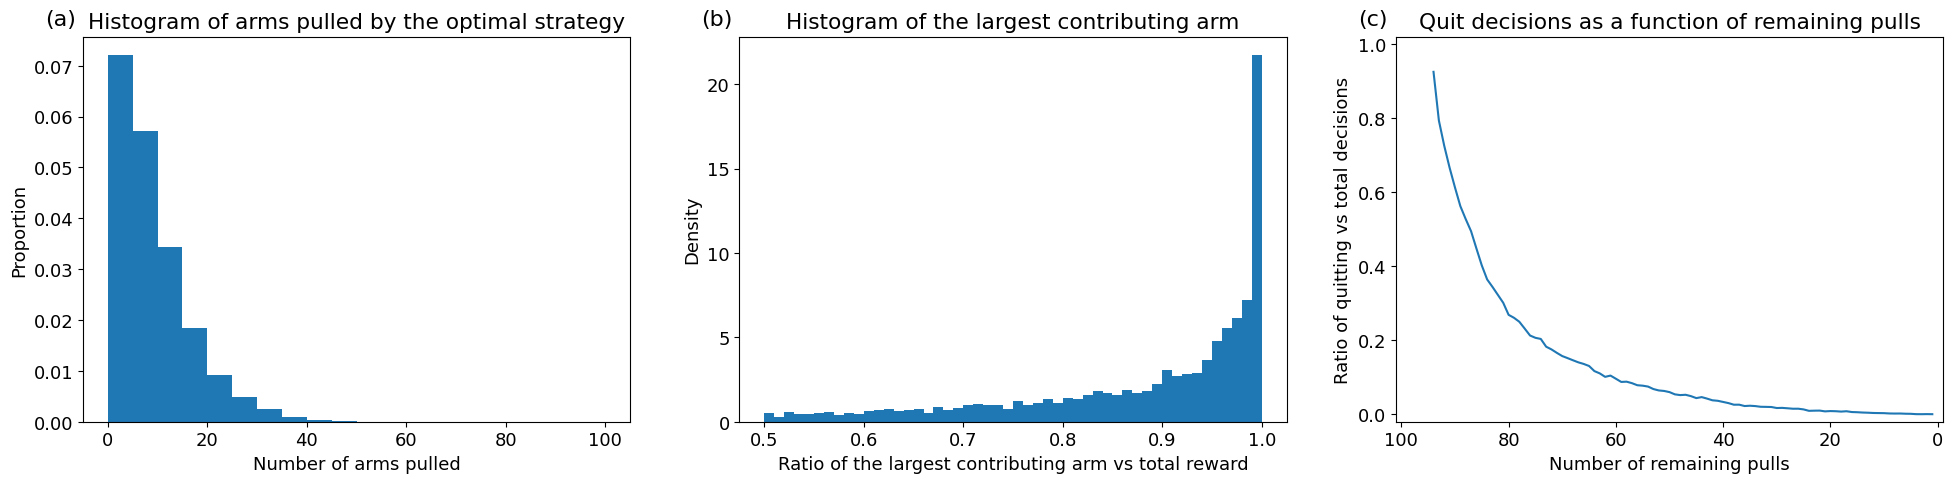

In [6]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(24,5))

ax = fig.add_subplot(131)
ax.set_title("Histogram of arms pulled by the optimal strategy")
ax.annotate("(a)", xy=(-0.07, 1.03), xycoords='axes fraction', fontsize=16)
ax.set_xlabel("Number of arms pulled")
ax.set_ylabel("Proportion")
ax.hist(num_buttons_simulation, density=True, bins=20, range=(0, 100))

ax = fig.add_subplot(132)
ax.set_title("Histogram of the largest contributing arm")
ax.annotate("(b)", xy=(-0.07, 1.03), xycoords='axes fraction', fontsize=16)
ax.set_xlabel("Ratio of the largest contributing arm vs total reward")
ax.set_ylabel("Density")
ax.hist(top_button_to_all_simulation, density=True, bins=50, range=(0.5,1))

ax = fig.add_subplot(133)
ax.set_title("Quit decisions as a function of remaining pulls")
ax.annotate("(c)", xy=(-0.07, 1.03), xycoords='axes fraction', fontsize=16)
ax.set_xlabel("Number of remaining pulls")
ax.set_xlim((-1,101))
ax.set_xticks(np.linspace(0, 100, num=6))
ax.set_ylabel("Ratio of quitting vs total decisions")
ax.set_ylim((-0.02,1.02))
ax.plot(decisions_aggregated[:,0], decisions_aggregated[:,1]/(decisions_aggregated[:,1]+decisions_aggregated[:,2]))
ax.invert_xaxis()

plt.savefig('Plots/model_sim.png',dpi=120,bbox_inches='tight')
plt.show()

# Optimal policy with probability truncation simulation

We start by investigating the behavior of the optimal strategy on three groups with probabilities capped at 0.9, 0.8 and 0.7

In [7]:
run_time = 100
number_of_runs = 50000
# button = sim.Button('Bernoulli', prior=(1, 1))
# button = sim.Button('Truncated', truncation=0.8)
policy = sim.Policy('Bernoulli', prior=(1, 1))
# policy = sim.Policy('Truncated', truncation=0.9)
# policy = sim.Policy('Difference', difference=4)
# policy = sim.Policy('Random', switch_probability=0.5)

truncations = [0.9, 0.8, 0.7]
plot_legend = ['Truncation ' + str(truncation) for truncation in truncations]

trial_records = []
decisions_processed = []

for trunc in truncations:
    button = sim.Button('Truncated', truncation=trunc)
    trial_record = sim.record_full_trials(run_time, number_of_runs, button, policy)
    trial_records.append(trial_record)
    decisions_processed.append(dp.Decision_Process(trial_record))
    
total_process = dp.Decision_Process(np.concatenate(trial_records))

In [8]:
for truncation, trunc_process in zip(truncations, decisions_processed):
    print('Fitting the optimal policy for the cap p = %.1lf' % truncation)
    decisions_to_use = trunc_process.get_decisions()
    print('Total number of stay decisions is %d' % np.count_nonzero(decisions_to_use[:,2] == 0))
    print('Total number of leave decisions is %d' % np.count_nonzero(decisions_to_use[:,2] == 1))
    print('')
    
    selected_decisions, cross_validation = logit.select_n_decisions(decisions_to_use, 100000, 100000, return_cross=True)
    
    regression = logit.BinaryLogisticRegression(selected_decisions[0], selected_decisions[1])
    regression.fit()
    
    print('\nRunning self-validation:')
    regression.cross_validation(regression.first_class, regression.second_class)
    print('\nRunning cross-validation:')
    regression.cross_validation(cross_validation[0], cross_validation[1]);
    print('')

Fitting the optimal policy for the cap p = 0.9
Total number of stay decisions is 2655350
Total number of leave decisions is 871147

MLE estimates:
Plane normal vector: [-1.04739496  3.22312526  0.05059196]
Plane intercept: -1.0924179928416669
MLE value: -15701.510860962171

MAP estimates:
Plane normal vector: [-1.04655331  3.21981033  0.05052297]
Plane intercept: -1.0877651582958836
MAP value: -15711.519062200343

Running self-validation:
Percentage of misidentified stay decisions: 3.37
Percentage of misidentified leave decisions: 1.70

Running cross-validation:
Percentage of misidentified stay decisions: 3.38
Percentage of misidentified leave decisions: 1.74

Fitting the optimal policy for the cap p = 0.8
Total number of stay decisions is 1579511
Total number of leave decisions is 1657624

MLE estimates:
Plane normal vector: [-1.25595123  3.00839703  0.05284592]
Plane intercept: -0.8421216631595528
MLE value: -22269.582506616774

MAP estimates:
Plane normal vector: [-1.25533209  3.006

Now we analize the combined data from the three cap groups

In [9]:
decisions_to_use = total_process.get_decisions(wins_more_fails=False)

print('Total number of stay decisions is %d' % np.count_nonzero(decisions_to_use[:,2] == 0))
print('Total number of leave decisions is %d' % np.count_nonzero(decisions_to_use[:,2] == 1))

selected_decisions, cross_validation = logit.select_n_decisions(decisions_to_use, 15000, 15000, return_cross=True)

regression = logit.BinaryLogisticRegression(selected_decisions[0], selected_decisions[1])
regression.fit()
print('Running cross-validation:')
regression.cross_validation(cross_validation[0], cross_validation[1]);

Total number of stay decisions is 5018135
Total number of leave decisions is 4941510
MLE estimates:
Plane normal vector: [-1.30099211  2.97275154  0.05223886]
Plane intercept: -0.5131511841143885
MLE value: -2790.2388229206676

MAP estimates:
Plane normal vector: [-1.29616708  2.9569672   0.05196218]
Plane intercept: -0.4973565395458367
MAP value: -2799.2817053551544
Running cross-validation:
Percentage of misidentified stay decisions: 3.91
Percentage of misidentified leave decisions: 2.38


100%|███████████████████████████████████████| 3000/3000 [00:39<00:00, 76.20it/s]


Autocorrelation times: [42.15965452 47.84820553 45.91480177 46.20538768]


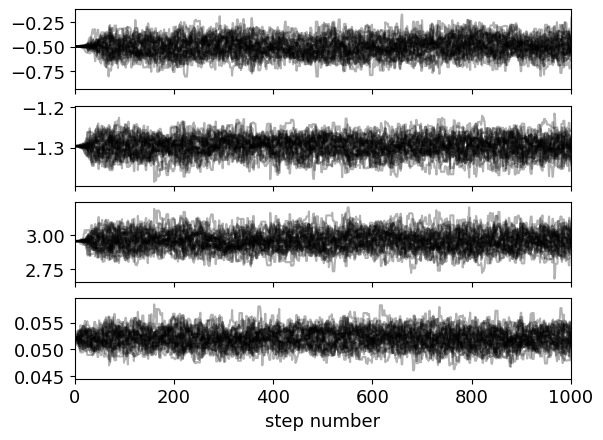

In [10]:
regression.run_mcmc(samples=3000)
regression.mcmc_diagnostic()

In [11]:
regression.analyze_mcmc(discard=100, thin=50, make_corner=False)

MCMC estimates:
Plane normal vector: [-1.29715875  2.95957516  0.05205206]
Plane vector deviations: [0.02245106 0.0647865  0.00169286]
Plane intercept: -0.5000844548284283
Plane intercept deviation: 0.0906340935665301


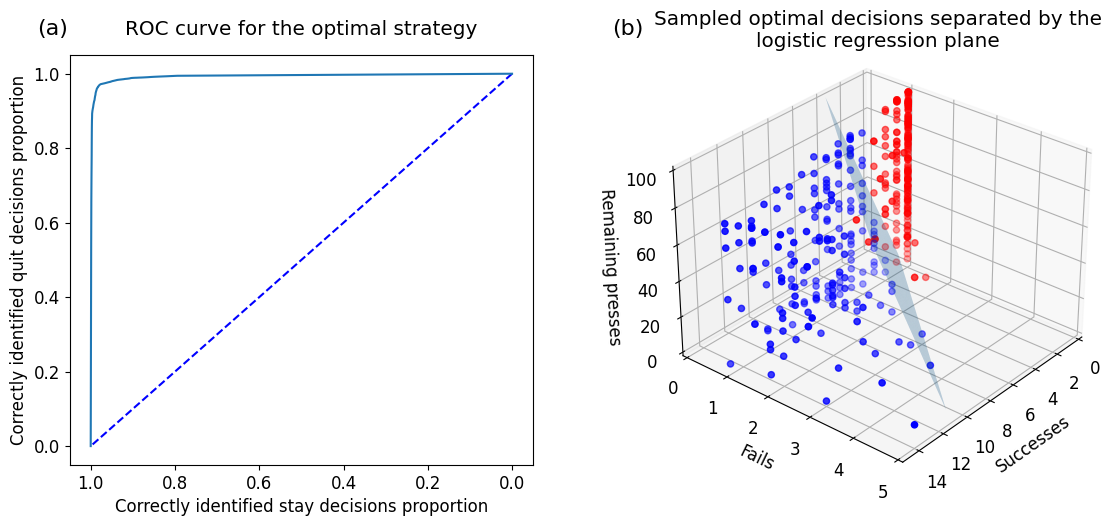

In [12]:
%matplotlib inline
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(121)
ax.annotate("(a)", xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=16)
probability_range = np.linspace(0.0, 1.0, 11)
ax.plot(probability_range, 1.0 - probability_range, 'b--')
ax.invert_xaxis()
ax.set_title("ROC curve for the optimal strategy", y=1.03)
ax.set_xlabel("Correctly identified stay decisions proportion")
ax.set_ylabel("Correctly identified quit decisions proportion")
regression.construct_roc_curve(cross_validation[0], cross_validation[1], plot_curve=True, plot=ax);

ax = fig.add_subplot(122, projection='3d')
ax.annotate("(b)", xy=(-0.15, 1.05), xycoords='axes fraction', fontsize=16)
ax.set_title("Sampled optimal decisions separated by the\nlogistic regression plane")
ax.set_xticks([0,2,4,6,8,10,12,14])
logit.plot_regression(selected_decisions,
                regression,
                max_wins = 15,
                max_fails = 5,
                n_plot = 200,
#                 transition_table=trans_table,
                plot=ax);
ax.view_init(30, 40)
ax.set_box_aspect(None, zoom=1.1)

plt.tight_layout(pad=3)
plt.savefig("Plots/optimal_roc_curve_regression.png",dpi=120)
plt.show()

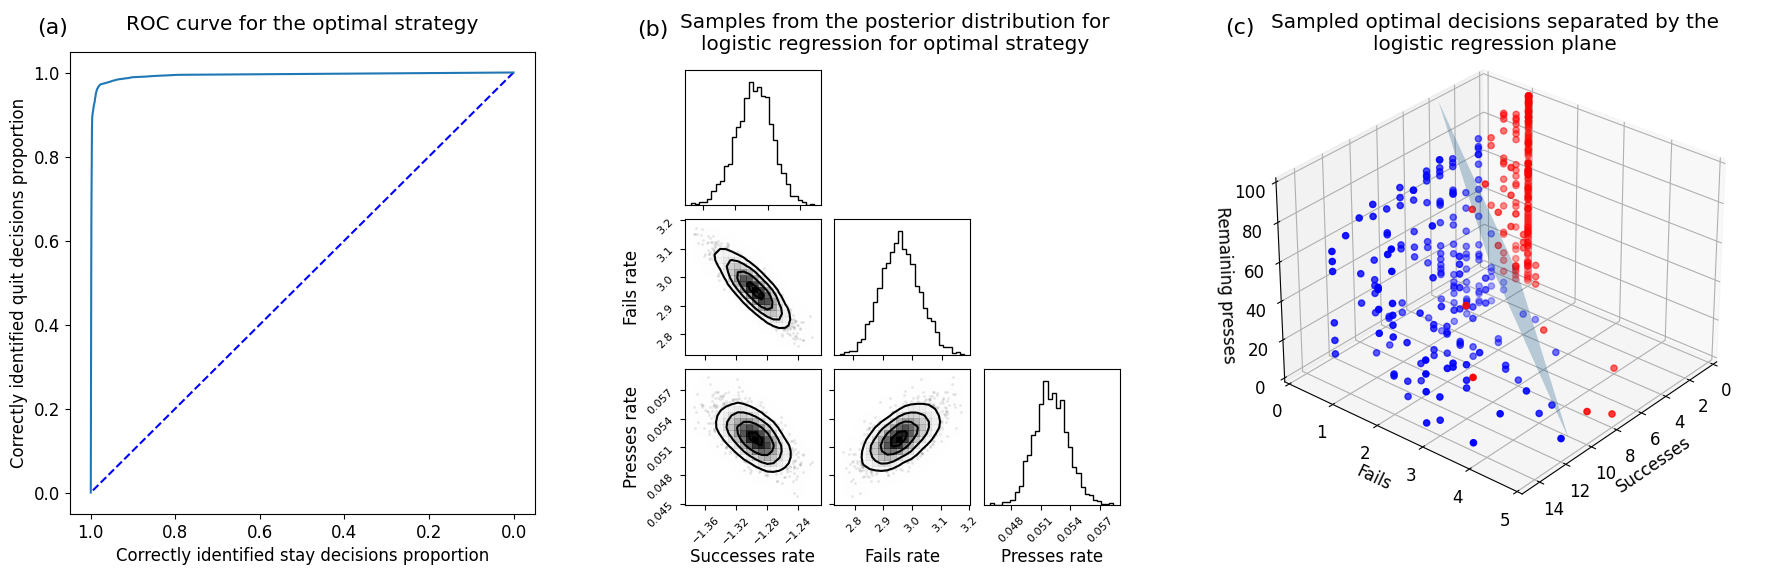

In [13]:
fig = plt.figure(figsize=(18,6))
subfigs = fig.subfigures(1, 3, wspace=0.07)
plt.rcParams.update({'font.size': 12})

ax = subfigs[0].add_subplot(111)
ax.annotate("(a)", xy=(-0.07, 1.04), xycoords='axes fraction', fontsize=16)
probability_range = np.linspace(0.0, 1.0, 11)
ax.plot(probability_range, 1.0 - probability_range, 'b--')
ax.invert_xaxis()
ax.set_title("ROC curve for the optimal strategy", y=1.03)
ax.set_xlabel("Correctly identified stay decisions proportion")
ax.set_ylabel("Correctly identified quit decisions proportion")
regression.construct_roc_curve(cross_validation[0], cross_validation[1], plot_curve=True, plot=ax);

subfigs[1].suptitle('Samples from the posterior distribution for\nlogistic regression for optimal strategy', y=0.945)
mcmc_samples = regression.mcmc_sampler.get_chain(discard=100, thin=40, flat=True)
logit.corner.corner(mcmc_samples[:,1:],
                labels=["Successes rate", "Fails rate", "Presses rate"],
                smooth=1,
                # label_kwargs={'fontsize': 12},
                hist_bin_factor=1.5,
                # labelpad=0.02,
                labelpad=0.02,
                fig=subfigs[1])
subfigs[1].axes[0].annotate("(b)", xy=(-0.35, 1.25), xycoords='axes fraction', fontsize=16)
for ax in subfigs[1].axes:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
subfigs[1].subplots_adjust(top = 0.85, bottom = 0.125, right = 0.875, left = 0.15, hspace = 0.1, wspace = 0.1)

ax = subfigs[2].add_subplot(111, projection='3d')
ax.annotate("(c)", xy=(0, 0.955), xycoords='axes fraction', fontsize=16)
ax.set_title("Sampled optimal decisions separated by the\nlogistic regression plane", y=0.99)
ax.set_xticks([0,2,4,6,8,10,12,14])
logit.plot_regression(selected_decisions,
                regression,
                max_wins = 15,
                max_fails = 5,
                n_plot = 200,
#                 transition_table=trans_table,
                plot=ax);
ax.view_init(30, 40)
ax.set_box_aspect(None, zoom=0.90)
subfigs[2].subplots_adjust(top = 1, bottom = 0, right = 0.95, left = 0.05, 
            hspace = 0, wspace = 0)

plt.savefig("Plots/optimal_roc_curve_regression_alt.png",dpi=300)
plt.show()